# Chapter 7

In [1]:
import logging

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tqdm

from aesara import shared
from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

#### Code 7.1

In [3]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


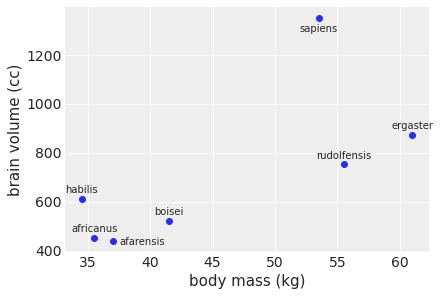

In [4]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

Moel fitting works better when we have a well behavied set of data.  Standardizing the data gives us that well behaved data to work with.  In particular we map brain mass to z-scores.  We map brain volume into the interval (0, 1]

#### Code 7.2

In [5]:
brains["mass_std"] = (brains["mass"] - brains["mass"].mean()) / brains["mass"]
brains["brain_std"] = brains["brain"] / brains["brain"].max()

We define first a simple linear model.

#### Code 7.3   

In [6]:
with pm.Model() as m7_1:
    sigma = pm.Lognormal("sigma", 0, 1)
    b = pm.Normal("b", 0, 10)
    a = pm.Normal("a", 0.5, 1)
    mu = pm.Deterministic("mu", a + b * brains["mass_std"].values)

    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9162, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
az.summary(trace_m7_1, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
b,0.72,0.50,0.01,1.54
a,0.56,0.10,0.41,0.73
sigma,0.27,0.12,0.12,0.41
mu[0],0.40,0.14,0.21,0.63
mu[1],0.36,0.16,0.14,0.62
mu[2],0.34,0.17,0.08,0.60
mu[3],0.49,0.11,0.33,0.65
mu[4],0.69,0.15,0.45,0.92
mu[5],0.75,0.18,0.48,1.05
mu[6],0.67,0.14,0.43,0.87


There are numerous ways to do linear regression in various python libraries. In [statsmodel](https://www.statsmodels.org/stable/index.html) there is [Ordinary Least Squares](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS).  In NumPy there is [np.polyfit()](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).  In the stats module of SciPy there is [scipy.stats.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).  And in [scikitlearn](https://scikit-learn.org/stable/index.html) you can fit a linear model to data with [sklearn.linear_model.LinearRegression()](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares).  The difference comes in how easy it is to get statistics about your fit model.  In `statsmodel` and `numpy` it is fairly easy.

For `statsmodel` you have a nice `summary()` method that can be called from the result of fitting the ordinary least squares.

#### Code 7.4

Using `statsmodel` to compute OLS we first need to create a design matrix.  In this case we are modeling a linear relationship between standardized brain volume `brain_std` and the normalized body mass `mass_std`.

In [8]:
from patsy import dmatrices

In [9]:
x, Y = dmatrices("brain_std ~ mass_std", data=brains)
model = sm.OLS(x, Y)
m_7_1 = model.fit()
m_7_1.summary()

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 10 Mar 2023   Prob (F-statistic):             0.0731
Time:                        10:59:42   Log-Likelihood:                 3.1020
No. Observations:                   7   AIC:                            -2.204
Df Residuals:                       5   BIC:                            -2.312
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5633      0.071      7.918      0.001       0.380       0.746
mass_std       0.7073      0.313      2.262      0.073      -0.096       1.511
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.536
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.814
Skew:                           1.245   Prob(JB):                        0.404
Kurtosis:                       3.129   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making use of the distribution found using the `statsmodel.ols()` method we can extract the varriance directly from the resulting fit object.  So `R code 7.5` would look like this.

In [11]:
1 - ( m_7_1.resid.var() / brains.brain_std.var())

0.5764545342109093

Alternativley, Using the NumPy `np.polyfit()` function, we can get the p-value as well as the covariance matrix (if `cov=True` is passed as an argument) as a result of our fitting the model.  Then we can sample from a simulated posterior distribution by using the [`scipy.stats.multivariat_normal().rvs()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html#numpy-random-multivariate-normal) method. Finaly we can create a dictionary object from those samples and use the ArviZ [az.summary()](https://python.arviz.org/en/stable/api/generated/arviz.summary.html?highlight=summary) method. 

In [10]:
p, cov = np.polyfit(brains["mass_std"], brains["brain_std"], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
b,0.714,0.305,0.268,1.236
a,0.563,0.070,0.464,0.691


However, we are going to be using our PyMC approach so we will use the `InferenceData` object `trace_m7_1`.  The text does the following: The `sim` function returns posterior predictive samples of brain size for each of our observations.  Then for each set of samples we will get the residual by first calculating the mean of the samples for each observation, and then subtract from that the observed brain size (standardized).  Next we compute the uncorrected varriance of those residuals and the uncorrected varriance of the observed brain size (standardized) and compute the $R^2$.  Here is how you could do that using the PyMC InferenceData object.

#### Code 7.5

In [12]:
# generate our posterior predictive samples.
s = pm.sample_posterior_predictive(trace_m7_1, model=m7_1).posterior_predictive.sel(chain=0).brain_std
# compute the difference between the predicted means for each observation and the standardized observed brain weight
r = s.mean(dim='draw') - brains.brain_std
# by default numpy uses 0 degrees of freedom in calculating varriance
resid_var = np.var(r.values)
outcome_var = np.var(brains.brain_std)
r_squared = (1 - (resid_var/outcome_var))

In [16]:
pm.sample_posterior_predictive(trace_m7_1, model=m7_1)

Inference data with groups:
	> posterior_predictive
	> observed_data

#### Code 7.6

In [13]:
def R2_is_bad(model):
    return 1 - model.resid.var() / brains.brain_std.var()


R2_is_bad(m_7_1)

0.5764545342109093

In [19]:
def R2_is_bad_2(trace, model):
    np.random.seed(12)
    # Each time this runs a new samples from the posterior will be drawn.  This means successive runs will have differing
    # R^2
    # generate our posterior predictive samples.
    s = pm.sample_posterior_predictive(trace=trace, model=model).posterior_predictive.sel(chain=0).brain_std
    # compute the difference between the predicted means for each observation and the standardized observed brain weight
    r = s.mean(dim='draw') - brains.brain_std
    # by default numpy uses 0 degrees of freedom for varriance
    resid_var = np.var(r.values)
    outcome_var = np.var(brains.brain_std)
    r_squared = (1 - (resid_var/outcome_var))
    return r_squared

In [20]:
R2_is_bad_2(trace_m7_1, m7_1)

0.5057868096178397

In [17]:
trace_m7_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [29]:
mass_std_seq = np.linspace(brains.mass_std.min(), brains.mass_std.max())
mass_seq = np.linspace(brains.mass.min(), brains.mass.max())

a = trace_m7_1.posterior.a.mean().item(0)
b = trace_m7_1.posterior.b.mean().item(0)

# mu_pred = np.zeros((len(mass_seq), nb_samples_thinned))
# for each weight that we are interested in
mu_pred = np.zeros(len(mass_std_seq))
for i, w in enumerate(mass_std_seq):
    # compute mu's using the 'a' and 'b' values at the current weight
    # and store them in our array
    mu_pred[i] = (a + b * w) * brains.brain.max()

In [35]:
mu_pred_m7_1 = trace_m7_1.posterior["mu"]

In [36]:
mu_pred_m7_1

<xarray.DataArray 'mu' (chain: 4, draw: 1000, mu_dim_0: 7)>
array([[[0.29181803, 0.23679824, 0.19746041, ..., 0.72586307,
         0.80413349, 0.69341111],
        [0.48871286, 0.46489587, 0.4478673 , ..., 0.67660245,
         0.71048418, 0.66255463],
        [0.41011801, 0.37623225, 0.35200475, ..., 0.67743901,
         0.72564443, 0.65745239],
        ...,
        [0.29499592, 0.23240208, 0.187649  , ..., 0.78879172,
         0.87783687, 0.75187241],
        [0.55037166, 0.52008651, 0.49843336, ..., 0.78928787,
         0.83237112, 0.77142498],
        [0.557981  , 0.5179565 , 0.48933995, ..., 0.87372983,
         0.93066815, 0.85012244]],

       [[0.4234526 , 0.38829653, 0.36316079, ..., 0.70079489,
         0.75080743, 0.68005901],
        [0.3115121 , 0.28686084, 0.26923578, ..., 0.50598315,
         0.54105171, 0.49144326],
        [0.6748821 , 0.66452093, 0.65711294, ..., 0.75662026,
         0.77135993, 0.75050899],
...
        [0.30455092, 0.26771246, 0.24137386, ..., 0.59516537,
         0.64757125, 0.57343718],
        [0.40482475, 0.38589677, 0.37236371, ..., 0.55414553,
         0.58107223, 0.54298136],
        [0.39656023, 0.34197741, 0.30295201, ..., 0.82715805,
         0.90480683, 0.79496382]],

       [[0.5881427 , 0.56332993, 0.5455894 , ..., 0.78388787,
         0.81918618, 0.76925272],
        [0.18264821, 0.12540392, 0.08447564, ..., 0.63424204,
         0.71567699, 0.60047801],
        [0.5152794 , 0.4791119 , 0.45325301, ..., 0.80060083,
         0.85205223, 0.77926838],
        ...,
        [0.57316427, 0.58970882, 0.60153778, ..., 0.44264614,
         0.41911009, 0.45240451],
        [0.42501095, 0.3807907 , 0.34917429, ..., 0.77385964,
         0.83676677, 0.74777749],
        [0.57850767, 0.54881905, 0.5275924 , ..., 0.81271791,
         0.85495254, 0.79520686]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6

In [50]:
samp_size = 100
slice_rate = int((trace_m7_1.posterior.dims['draw'] + trace_m7_1.posterior.dims['chain']) / samp_size)

trace_m7_1_thinned = trace_m7_1.sel(draw=slice(None, None, slice_rate))
with m7_1:
    brain_pred = pm.sample_posterior_predictive(trace_m7_1_thinned)

In [55]:
brain_pred.posterior_predictive.brain_std.sel(chain=0)
# az.hdi(mass_pred.posterior_predictive["mass"])

<xarray.DataArray 'brain_std' (draw: 100, brain_std_dim_0: 7)>
array([[ 0.45587294,  0.50415703,  0.5042611 , -0.19287283,  0.59331323,
         0.78469103,  0.69261956],
       [ 0.38354746,  0.21940786,  0.18318059,  0.52569044,  0.91725618,
         0.86021892,  0.73433334],
       [ 0.03699817,  0.1092715 ,  0.13331197,  0.31276815,  0.83331538,
         0.64491878,  0.57191306],
       [ 0.30542437,  0.44559329,  0.15771845,  0.80826782,  0.61555431,
         0.7206572 ,  0.77748034],
       [ 0.50887446,  0.4109891 ,  0.50938174,  0.94087116,  0.21122738,
         0.70181198,  0.44251732],
       [ 0.05012097, -1.06033871, -0.0701559 ,  0.23613115,  0.09123994,
         0.31560027,  0.75521426],
       [ 0.73082607,  0.11814324,  0.07546653,  0.8706387 ,  0.82778159,
         1.06298954,  0.39189397],
       [ 0.59018962,  0.49505303,  0.31939032,  0.63283133,  0.91457218,
         0.99241023,  0.87336525],
       [ 0.71180343,  0.84880105, -0.20866066,  0.44107285,  1.4944893 ,
         0.28724004,  0.83469502],
       [-0.04480561,  0.7095912 ,  0.21322037,  0.54593806,  0.68958429,
         0.73225575,  0.54365665],
...
       [ 0.56388502,  0.2588231 ,  0.66939259,  0.66396804,  0.71118056,
         0.47003575,  0.65025382],
       [ 0.27278784,  0.32049996,  0.28198505,  0.49545203,  0.85238318,
         1.080901  ,  1.14131405],
       [-0.67346676,  0.12017685, -0.94875983,  1.15033706,  0.04496572,
         1.86646314,  1.89888687],
       [ 0.08150746,  0.36495746,  0.35968422,  0.44944518,  0.62776844,
         0.84803372,  0.65760432],
       [ 0.20841298,  0.11399315, -0.31326012,  0.5841874 ,  1.18275314,
         0.804267  ,  0.94649465],
       [-0.00688453, -0.0722177 ,  0.22720667,  0.8275972 ,  0.51824809,
         0.86993765,  0.79183456],
       [ 0.68289766,  0.30108231,  0.538747  ,  0.31016855,  0.7576727 ,
         0.64886389,  0.99527559],
       [ 0.13449037,  0.50200629,  0.26944462,  0.83318725,  0.50397202,
         0.29769287,  0.20102376],
       [ 0.25132985, -0.18884285, -0.33017284, -0.02896368,  0.8830676 ,
         1.04017599,  0.84640231],
       [-0.03398447,  0.33852348,  0.29065261,  0.74063989,  0.46343328,
         1.01024162,  0.79970131]])
Coordinates:
    chain            int64 0
  * draw             (draw) int64 0 10 20 30 40 50 ... 940 950 960 970 980 990
  * brain_std_dim_0  (brain_std_dim_0) int64 0 1 2 3 4 5 6

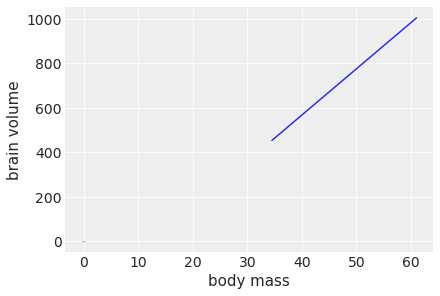

In [31]:

plt.plot(mass_seq, mu_pred, "C0")
az.plot_hdi(brains.mass_std, mu_pred_m7_1, hdi_prob=0.89)
plt.xlabel("body mass")
plt.ylabel("brain volume");

#### Code 7.7

Using PyMC

In [323]:
with pm.Model() as m7_2:
    sigma = pm.LogNormal("sigma", 0, 1)
    b1 = pm.Normal("b1", 0, 10)
    b2 = pm.Normal("b2", 0, 10)
    a = pm.Normal("a", 0.5, 1)
    # quadratic model for mean mass
    mu =pm.Deterministic("mu", \
        a \
        + b1 * brains["mass_std"].values \
        + b2 * brains["mass_std"].values **2
    )

    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_2 = pm.sample(tune=2000, nuts={'target_accept':0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b2, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


In [324]:
mass_m7_3 = np.vstack((brains.mass_std, brains.mass_std**2, brains.mass_std**3))

with pm.Model() as m7_3:
    sigma = pm.LogNormal("sigma", 0, 1)
    # using the tools to make the code look simpler
    b = pm.Normal("b1", 0, 10, shape=3)
    a = pm.Normal("a", 0.5, 1)
    # cubic model for mean mass
    mu = pm.Deterministic("mu", a + pm.math.dot(b, mass_m7_3))
    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_3 = pm.sample(tune=2000, nuts={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


In [325]:
mass_m7_4 = np.vstack((brains.mass_std, brains.mass_std**2, brains.mass_std**3, brains.mass_std**4))

with pm.Model() as m7_4:
    sigma = pm.LogNormal("sigma", 0, 1)
    b = pm.Normal("b", 0, 10, shape=4)
    a = pm.Normal("a", 0.5, 1)
    # quartic model for mean mass
    mu = pm.Deterministic("mu", a + pm.math.dot(b, mass_m7_4))

    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_4 = pm.sample(tune=2000, nuts={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


In [326]:
mass_m7_5 = np.vstack((brains.mass_std, brains.mass_std**2, brains.mass_std**3, brains.mass_std**4, brains.mass_std**5))

with pm.Model() as m7_5:
    sigma = pm.LogNormal("sigma", 0, 1)
    b = pm.Normal("b", 0, 10, shape=5)
    a = pm.Normal("a", 0.5, 1)
    # quartic model for mean mass
    mu = pm.Deterministic("mu", a + pm.math.dot(b, mass_m7_5))
    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_5 = pm.sample(tune=3000,  nuts={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 32 seconds.


In [327]:
mass_m7_6 = np.vstack((brains.mass_std, brains.mass_std**2, brains.mass_std**3, brains.mass_std**4, brains.mass_std**5, brains.mass_std**6))

with pm.Model() as m7_6:
    sigma = pm.LogNormal("sigma", 0, 1)
    b = pm.Normal("b", 0, 10, shape=6)
    a = pm.Normal("a", 0.5, 1)
    # quartic model for mean mass
    mu = pm.Deterministic("mu", a + pm.math.dot(b, mass_m7_6))
    
    brain_std = pm.Normal("brain_std", mu, sigma, observed=brains["brain_std"].values)

    trace_m7_6 = pm.sample(tune=2000,  nuts={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.


Now that we have defined all of our models of degree 1 through 6, lets plot them with the corresponding $R^2$.

In [311]:
mu_pred = trace_m7_1.posterior["mu"]
trace_m7_1_thinned = trace_m7_1.sel(draw=slice(None, None, 5))
with m7_1:
    brain_pred = pm.sample_posterior_predictive(trace_m7_1_thinned)

data_m7_1 = az.extract_dataset(trace_m7_1)

mass_seq = np.linspace(33, 67)
# How many samples do we have?
nb_samples = trace_m7_1.posterior.dims['chain'] *  trace_m7_1.posterior.dims['draw']
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# for example we can use every tenth sample
trace_m7_1_thinned = data_m7_1.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_m7_1_thinned.sizes["sample"]
# define an array to store our data in.  This will be a matrix with each row being the samples from 
# the posterior for mu
mu_pred = np.zeros((len(mass_seq), nb_samples_thinned))
# for each weight that we are interested in
for i, w in enumerate(mass_seq):
    # compute mu's for all thinned sample of 'a' and 'b' values at the current weight
    # and store them in our array
    mu_pred[i] = trace_m7_1_thinned["a"] + trace_m7_1_thinned["b"] * (w - brains.mass.mean())

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


TypeError: Dimension mismatch for x: (7,) and hdi: (400, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible

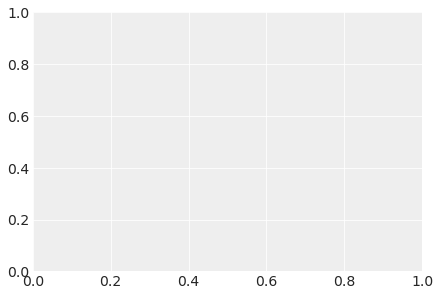

In [314]:
# ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
# az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
# plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)
fig, ax = plt.subplots()
a = trace_m7_1.posterior.a.mean().values
b = trace_m7_1.posterior.b.mean().values

# pred = pm.sample_posterior_predictive(trace=trace_m7_2, model=m7_2).sel(chain=0)
az.plot_hdi(brains.mass, mu_pred, hdi_prob=0.89, ax=ax)
plt.plot(mass_seq, mu_pred, "k")
#az.plot_hdi(brains.mass_std, brain_pred.posterior_predictive["brain_std"], hdi_prob=0.89)
plt.scatter(brains.mass, brains.brain, c="C0", alpha=0.3)

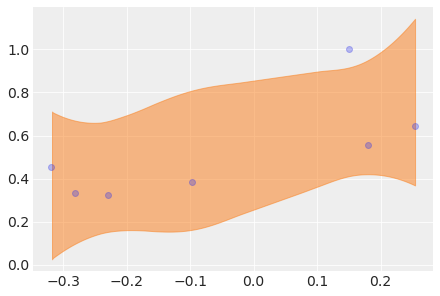

In [289]:
mu_pred_m7_2 = trace_m7_2.posterior["mu"]
trace_m7_2_thinned = trace_m7_2.sel(draw=slice(None, None, 5))
with m7_2:
    brain_pred_m7_2 = pm.sample_posterior_predictive(trace_m7_2_thinned)

# pred = pm.sample_posterior_predictive(trace=trace_m7_2, model=m7_2).sel(chain=0)
ax = az.plot_hdi(brains.mass_std, mu_pred_m7_2, hdi_prob=0.89)
#az.plot_hdi(brains.mass_std, brain_pred.posterior_predictive["brain_std"], hdi_prob=0.89)
plt.scatter(brains.mass_std, brains.brain_std, c="C0", alpha=0.3)

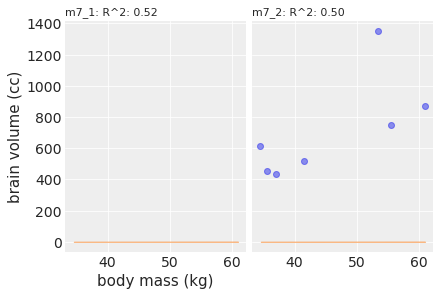

In [297]:
# models = [m7_1, m7_2, m7_3, m7_4, m7_5, m7_6]
# traces = [trace_m7_1, trace_m7_2, trace_m7_3, trace_m7_4, trace_m7_5, trace_m7_6]
# names = ["m7_1", "m7_2", "m7_3", "m7_4", "m7_5", "m7_6"]
models = [m7_1, m7_2]
traces = [trace_m7_1, trace_m7_2]
names = ["m7_1", "m7_2"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(1, 2, figsize=[6, 4], sharex=True, sharey="row")

for trace, model, name, ax in zip(traces, models, names, axs.flat):
    pred = trace.posterior["mu"]
    # pred = pm.sample_posterior_predictive(trace=trace, model=model).sel(chain=0)
    az.plot_hdi(brains.mass, pred, hdi_prob=0.89, ax=ax)
    plt.scatter(brains.mass, brains.brain, c="C0", alpha=0.3)

    # prediction = model.get_prediction({"mass_std": mass_new})
    # pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    # ax.plot(mass_plot, pred["mean"])
    # ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    # ax.scatter(brains.mass, brains.brain, color="C0", s=15)
    r2 = R2_is_bad_2(trace, model)
    ax.set_title(f"{name}: R^2: {r2:.2f}", loc="left", fontsize=11)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.get_subplotspec().is_first_col():
        ax.set_xlabel("body mass (kg)")

    # if ax.get_subplotspec().is_first_col():
    #     ax.set_ylim(-500, 2100)
    #     ax.axhline(0, ls="dashed", c="k", lw=1)
    #     ax.set_yticks([0, 450, 1300])
    # else:
    #     ax.set_ylim(300, 1600)
    #     ax.set_yticks([450, 900, 1300])

In [228]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     2.054
Date:                Mon, 23 Jan 2023   Prob (F-statistic):              0.243
Time:                        20:20:47   Log-Likelihood:                 3.1075
No. Observations:                   7   AIC:                           -0.2150
Df Residuals:                       4   BIC:                           -0.3773
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5519      0.165      3.351      0.029       0.095       1.009
mass_std             0.7240      0.408      1.774      0.151      -0.409       1.857
I(mass_std ** 2)     0.2362      2.986      0.079      0.941      -8.054       8.526
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.542
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.962
Skew:                           1.291   Prob(JB):                        0.375
Kurtosis:                       3.255   Cond. No.                         38.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.8

In [229]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

#### Code 7.9

In [230]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

#### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


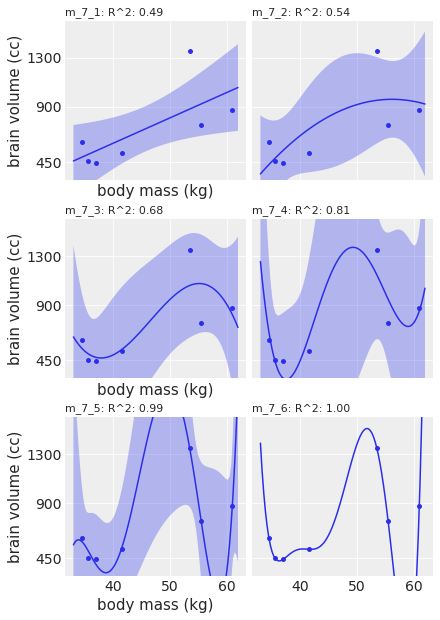

In [13]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

# create list of masses that we will be sampling the posterior for
mass_plot = np.linspace(33, 62, 100)
# standardize
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.get_subplotspec().is_first_col():
        ax.set_xlabel("body mass (kg)")

    if ax.get_subplotspec().is_first_col():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

#### Code 7.11 - this is R specific notation for dropping rows

In [14]:
brains_new = brains.drop(brains.index[-1])

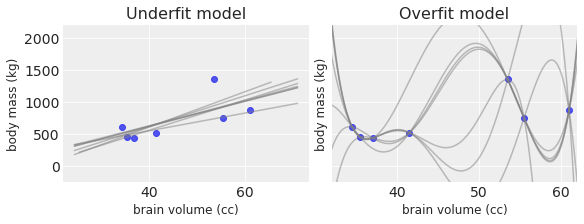

In [15]:
# Figure 7.4

# this code taken from PyMC port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

#### Code 7.12

In [16]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

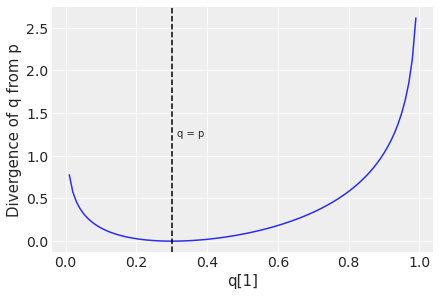

In [17]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

#### Code 7.13 & 7.14

In [18]:
n_samples = 3000

intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T

pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)

n, ns = pred.shape

In [19]:
# PyMC does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.62060273,  0.66080837,  0.56608632,  0.62876608,  0.47909493,
        0.44851465, -0.8559313 ])

#### Code 7.15

In [20]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [21]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.54799078,  2.3115561 ,  2.89843278,  3.53621752, 11.04367575])

#### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [22]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            initval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

    with m_sim:
        trace_m_sim = pm.sample(samples, progressbar=False)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

In [23]:
# This cell is expected have a long run time
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

# setting log output to error
logger = logging.getLogger("pymc")
init_level = logger.level
logger.setLevel(logging.ERROR)

for j in range(2, param + 1):
    print(f"Num Params: {j}")
    for i in tqdm.tqdm(range(1, tries + 1)):
        tr, te = sim_train_test(N=n, k=param, samples=1000)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

# resetting logger level
logger.setLevel(init_level)

Num Params: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:36<00:00, 27.60s/it]


Num Params: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:10<00:00, 31.04s/it]


Num Params: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:26<00:00, 26.64s/it]


Num Params: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:31<00:00, 27.16s/it]


Num Params: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.53s/it]


#### Code 7.17

Does not apply because multi-threading is automatic in PyMC.

#### Code 7.18

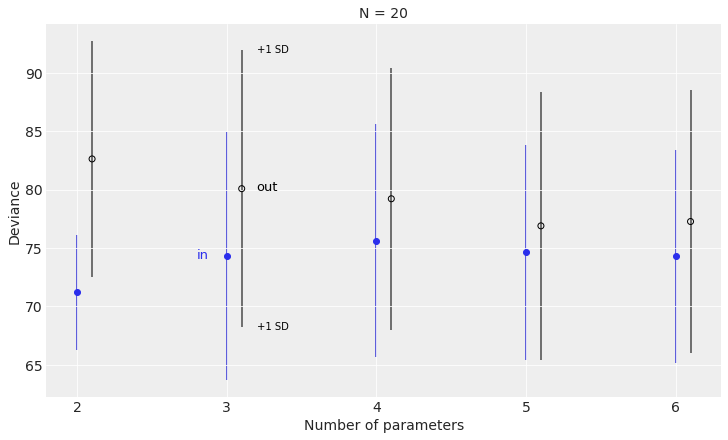

In [24]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

#### Code 7.19

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

In [25]:
data = pd.read_csv("Data/cars.csv", sep=",", index_col=0)

In [26]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"].values)
    dist = pm.Normal("dist", mu=mu, sigma=sigma, observed=data["dist"].values)
    m = pm.sample(5000, tune=10000)

post = az.extract_dataset(m.posterior)
post = post.sel(draw=slice(None, None, int(len(post.sample) / 1000)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 68 seconds.


#### Code 7.20

In [27]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = post["a"][s].values + post["b"][s].values * data["speed"].values
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=post["sigma"][s])
    logprob[:, s] = p_

#### Code 7.21

In [28]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

#### Code 7.22

In [29]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])

#### Code 7.23

In [30]:
-2 * (sum(lppd) - sum(pWAIC))

412.57636598830624

#### Code 7.24

In [31]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec)) ** 0.5

15.022211089365513

#### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [32]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


#### Code 7.25

In [33]:
az.waic(m_6_7_trace, m_6_7, scale="deviance")

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   321.55    13.19
p_waic            3.43        -

#### Code 7.26

In [34]:
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,321.552649,3.429377,0.000000,1.000000e+00,13.186030,0.000000,False,deviance
m_6_8,1,406.079856,2.778572,84.527208,4.417231e-19,12.682459,12.461968,False,deviance
m_6_6,2,423.488372,1.629363,101.935724,7.327213e-23,11.507223,12.825019,False,deviance


#### Code 7.27

In [35]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

array(12.46196794)

#### Code 7.28

In [36]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

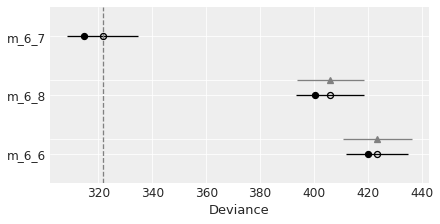

In [37]:
az.plot_compare(compare_df);

#### Code 7.30

In [38]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale="deviance")

diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i

n = len(diff_m6_6_m6_8)

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(9.82681401)

#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison. This is not implemented in `arviz`, but we can hack it together:

In [39]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

,m_6_7,m_6_8
m_6_8,12.461968,0.000000
m_6_6,12.825019,9.826814


**Note:** this work for three models, but will get increasingly hack-y with additional models. The function below can be applied to *n* models:

In [40]:
def pairwise_compare(dataset_dict, metric="dse", **kwargs):
    """
    Calculate pairwise comparison of models in dataset_dict.

    Parameters
    ----------
    dataset_dict : dict
        A dict containing two ore more {'name': pymc.backends.base.MultiTrace}
        items.
    metric : str
        The name of the matric to be calculated. Can be any valid column output
        by `arviz.compare`. Note that this may change depending on the **kwargs
        that are specified.
    kwargs
        Arguments passed to `arviz.compare`
    """
    data_dict = dataset_dict.copy()
    dicts = []

    while len(data_dict) > 1:
        c = az.compare(data_dict, **kwargs)[metric]
        dicts.append(c.to_frame(name=c.index[0]))
        del data_dict[c.index[0]]

    return pd.concat(dicts, axis=1)

In [41]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

pairwise_compare(dataset_dict, metric="dse", ic="waic", scale="deviance")

,m_6_7,m_6_8
m_6_7,0.000000,NaN
m_6_8,12.461968,0.000000
m_6_6,12.825019,9.826814


#### Code 7.32

In [42]:
d = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [43]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_3_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


#### Code 7.33

In [44]:
az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance",
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,127.143587,3.864388,0.000000,0.894438,12.849013,0.000000,False,deviance
m_5_3,1,128.580403,4.723429,1.436816,0.000000,12.719896,0.803879,False,deviance
m_5_2,2,140.720326,3.134333,13.576739,0.105562,9.846951,9.355108,False,deviance


#### Code 7.34

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


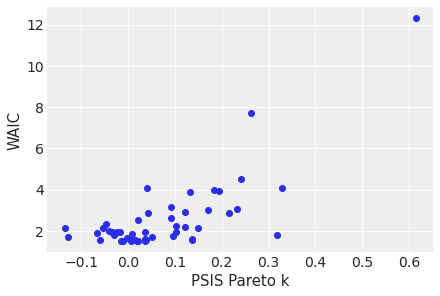

In [45]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

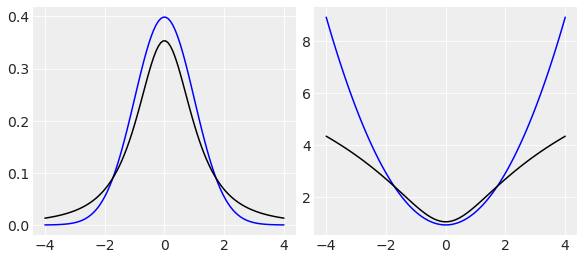

In [46]:
# Figure 7.11

v = np.linspace(-4, 4, 100)

g = stats.norm(loc=0, scale=1)
t = stats.t(df=2, loc=0, scale=1)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.pdf(v), color="b")
ax.plot(v, t.pdf(v), color="k")

lax.plot(v, -g.logpdf(v), color="b")
lax.plot(v, -t.logpdf(v), color="k");

#### Code 7.35

In [47]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=d["D"].values)

    m_5_3t_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [48]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   133.98    11.50
p_loo            6.28        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w